In [1]:
import logging

import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from utils.load_dataset import load_dataset

tf.get_logger().setLevel(logging.ERROR)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2024-04-24 15:25:08.206338: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-24 15:25:08.206381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-24 15:25:08.207622: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-24 15:25:08.213562: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-24 15:25:08.946753: W tensorflow/compiler/tf2

Загрузим данные, разбив на тренировочную, валидационную и тестовую выборки:

In [2]:
train_ds, val_ds, test_ds = load_dataset()

Found 19794 files belonging to 40 classes.
Using 13856 files for training.


2024-04-24 15:25:12.195274: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 15:25:12.195529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-24 15:25:12.195674: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 19794 files belonging to 40 classes.
Using 5938 files for validation.


Загрузим базовую модель InceptionV3 без верхних слоев:

In [3]:
base_model = tf.keras.applications.InceptionV3(input_shape=(256, 256, 3),
                                               include_top=False,
                                               weights='imagenet')

Заморозим слои, чтобы веса не обновлялись во время обучения:

In [4]:
base_model.trainable = False

Определим архитектуру нашей модели:

In [5]:
inputs = tf.keras.Input(shape=(256, 256, 3))
preprocess =  tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(preprocess, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(40, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [6]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                             

Начнем обучение модели с замороженными нижними слоями:

In [7]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

Определим наши коллбэк-функции:

In [8]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_checkpoints/inception_v3.weights.h5",
    save_weights_only=True)

es = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=2,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0
)

In [9]:
%%time
history_1 = model.fit(train_ds,
                      epochs=20,
                      validation_data=val_ds,
                      callbacks=[checkpoint_cb, es])

Epoch 1/20


2024-04-24 15:25:47.008736: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-04-24 15:25:47.232436: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-24 15:25:51.316907: I external/local_xla/xla/service/service.cc:168] XLA service 0x737110b72020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 15:25:51.316928: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2024-04-24 15:25:51.322563: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1713947151.392521  104729 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


433/433 [==============================] - ETA: 0s - loss: 2.6371 - accuracy: 0.3025

2024-04-24 15:26:34.707894: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 147303717 exceeds 10% of free system memory.


433/433 [==============================] - 59s 117ms/step - loss: 2.6371 - accuracy: 0.3025 - val_loss: 1.8597 - val_accuracy: 0.5037
Epoch 2/20
433/433 [==============================] - ETA: 0s - loss: 1.8159 - accuracy: 0.4865

2024-04-24 15:27:24.993695: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 147303717 exceeds 10% of free system memory.


433/433 [==============================] - 48s 110ms/step - loss: 1.8159 - accuracy: 0.4865 - val_loss: 1.5661 - val_accuracy: 0.5682
Epoch 3/20
433/433 [==============================] - ETA: 0s - loss: 1.5717 - accuracy: 0.5485

2024-04-24 15:28:12.620081: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 147303717 exceeds 10% of free system memory.


433/433 [==============================] - 47s 109ms/step - loss: 1.5717 - accuracy: 0.5485 - val_loss: 1.4313 - val_accuracy: 0.5945
Epoch 4/20
433/433 [==============================] - ETA: 0s - loss: 1.4276 - accuracy: 0.5870

2024-04-24 15:29:00.439534: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 147303717 exceeds 10% of free system memory.


433/433 [==============================] - 48s 110ms/step - loss: 1.4276 - accuracy: 0.5870 - val_loss: 1.3521 - val_accuracy: 0.6155
Epoch 5/20
433/433 [==============================] - ETA: 0s - loss: 1.3183 - accuracy: 0.6210

2024-04-24 15:29:48.727511: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 147303717 exceeds 10% of free system memory.


433/433 [==============================] - 48s 111ms/step - loss: 1.3183 - accuracy: 0.6210 - val_loss: 1.3105 - val_accuracy: 0.6209
Epoch 6/20
433/433 [==============================] - 48s 111ms/step - loss: 1.2320 - accuracy: 0.6431 - val_loss: 1.2905 - val_accuracy: 0.6229
Epoch 7/20
433/433 [==============================] - 48s 111ms/step - loss: 1.1635 - accuracy: 0.6618 - val_loss: 1.2312 - val_accuracy: 0.6435
Epoch 8/20
433/433 [==============================] - 47s 109ms/step - loss: 1.1046 - accuracy: 0.6778 - val_loss: 1.2199 - val_accuracy: 0.6475
Epoch 9/20
433/433 [==============================] - 48s 110ms/step - loss: 1.0486 - accuracy: 0.6945 - val_loss: 1.1867 - val_accuracy: 0.6512
Epoch 10/20
433/433 [==============================] - 48s 110ms/step - loss: 1.0022 - accuracy: 0.7068 - val_loss: 1.1630 - val_accuracy: 0.6634
Epoch 11/20
433/433 [==============================] - 47s 109ms/step - loss: 0.9583 - accuracy: 0.7198 - val_loss: 1.1639 - val_accuracy: 0

Так как число параметров в нижних слоях огромно (более 21 миллиона), то мы не будем размораживать \
нижние слои для тренировки в силу ограниченных вычислительных мощностей.

In [10]:
results = model.evaluate(test_ds)

93/93 [==============================] - 8s 81ms/step - loss: 1.0928 - accuracy: 0.6828


In [11]:
results

[1.092821478843689, 0.6827957034111023]

Посомтрим несколько предсказаний:

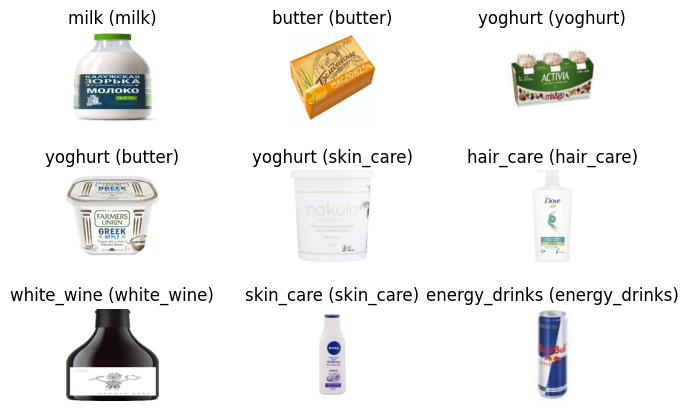

In [12]:
class_names = train_ds.class_names
IMAGE_NUM = 2
for i, (images, labels) in enumerate(test_ds):
    if i == 9:
        break
    ax = plt.subplot(3, 3, i + 1)
    im = np.expand_dims(images[IMAGE_NUM].numpy(), axis=0)
    prediction = class_names[np.argmax(model.predict(im, verbose=0)[0])]
    plt.imshow(images[IMAGE_NUM, ...].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels.numpy()[IMAGE_NUM])] + f' ({prediction})')
    plt.axis("off")
    plt.subplots_adjust(left=None, bottom=None, right=1.1, top=None, wspace=None, hspace=0.5)


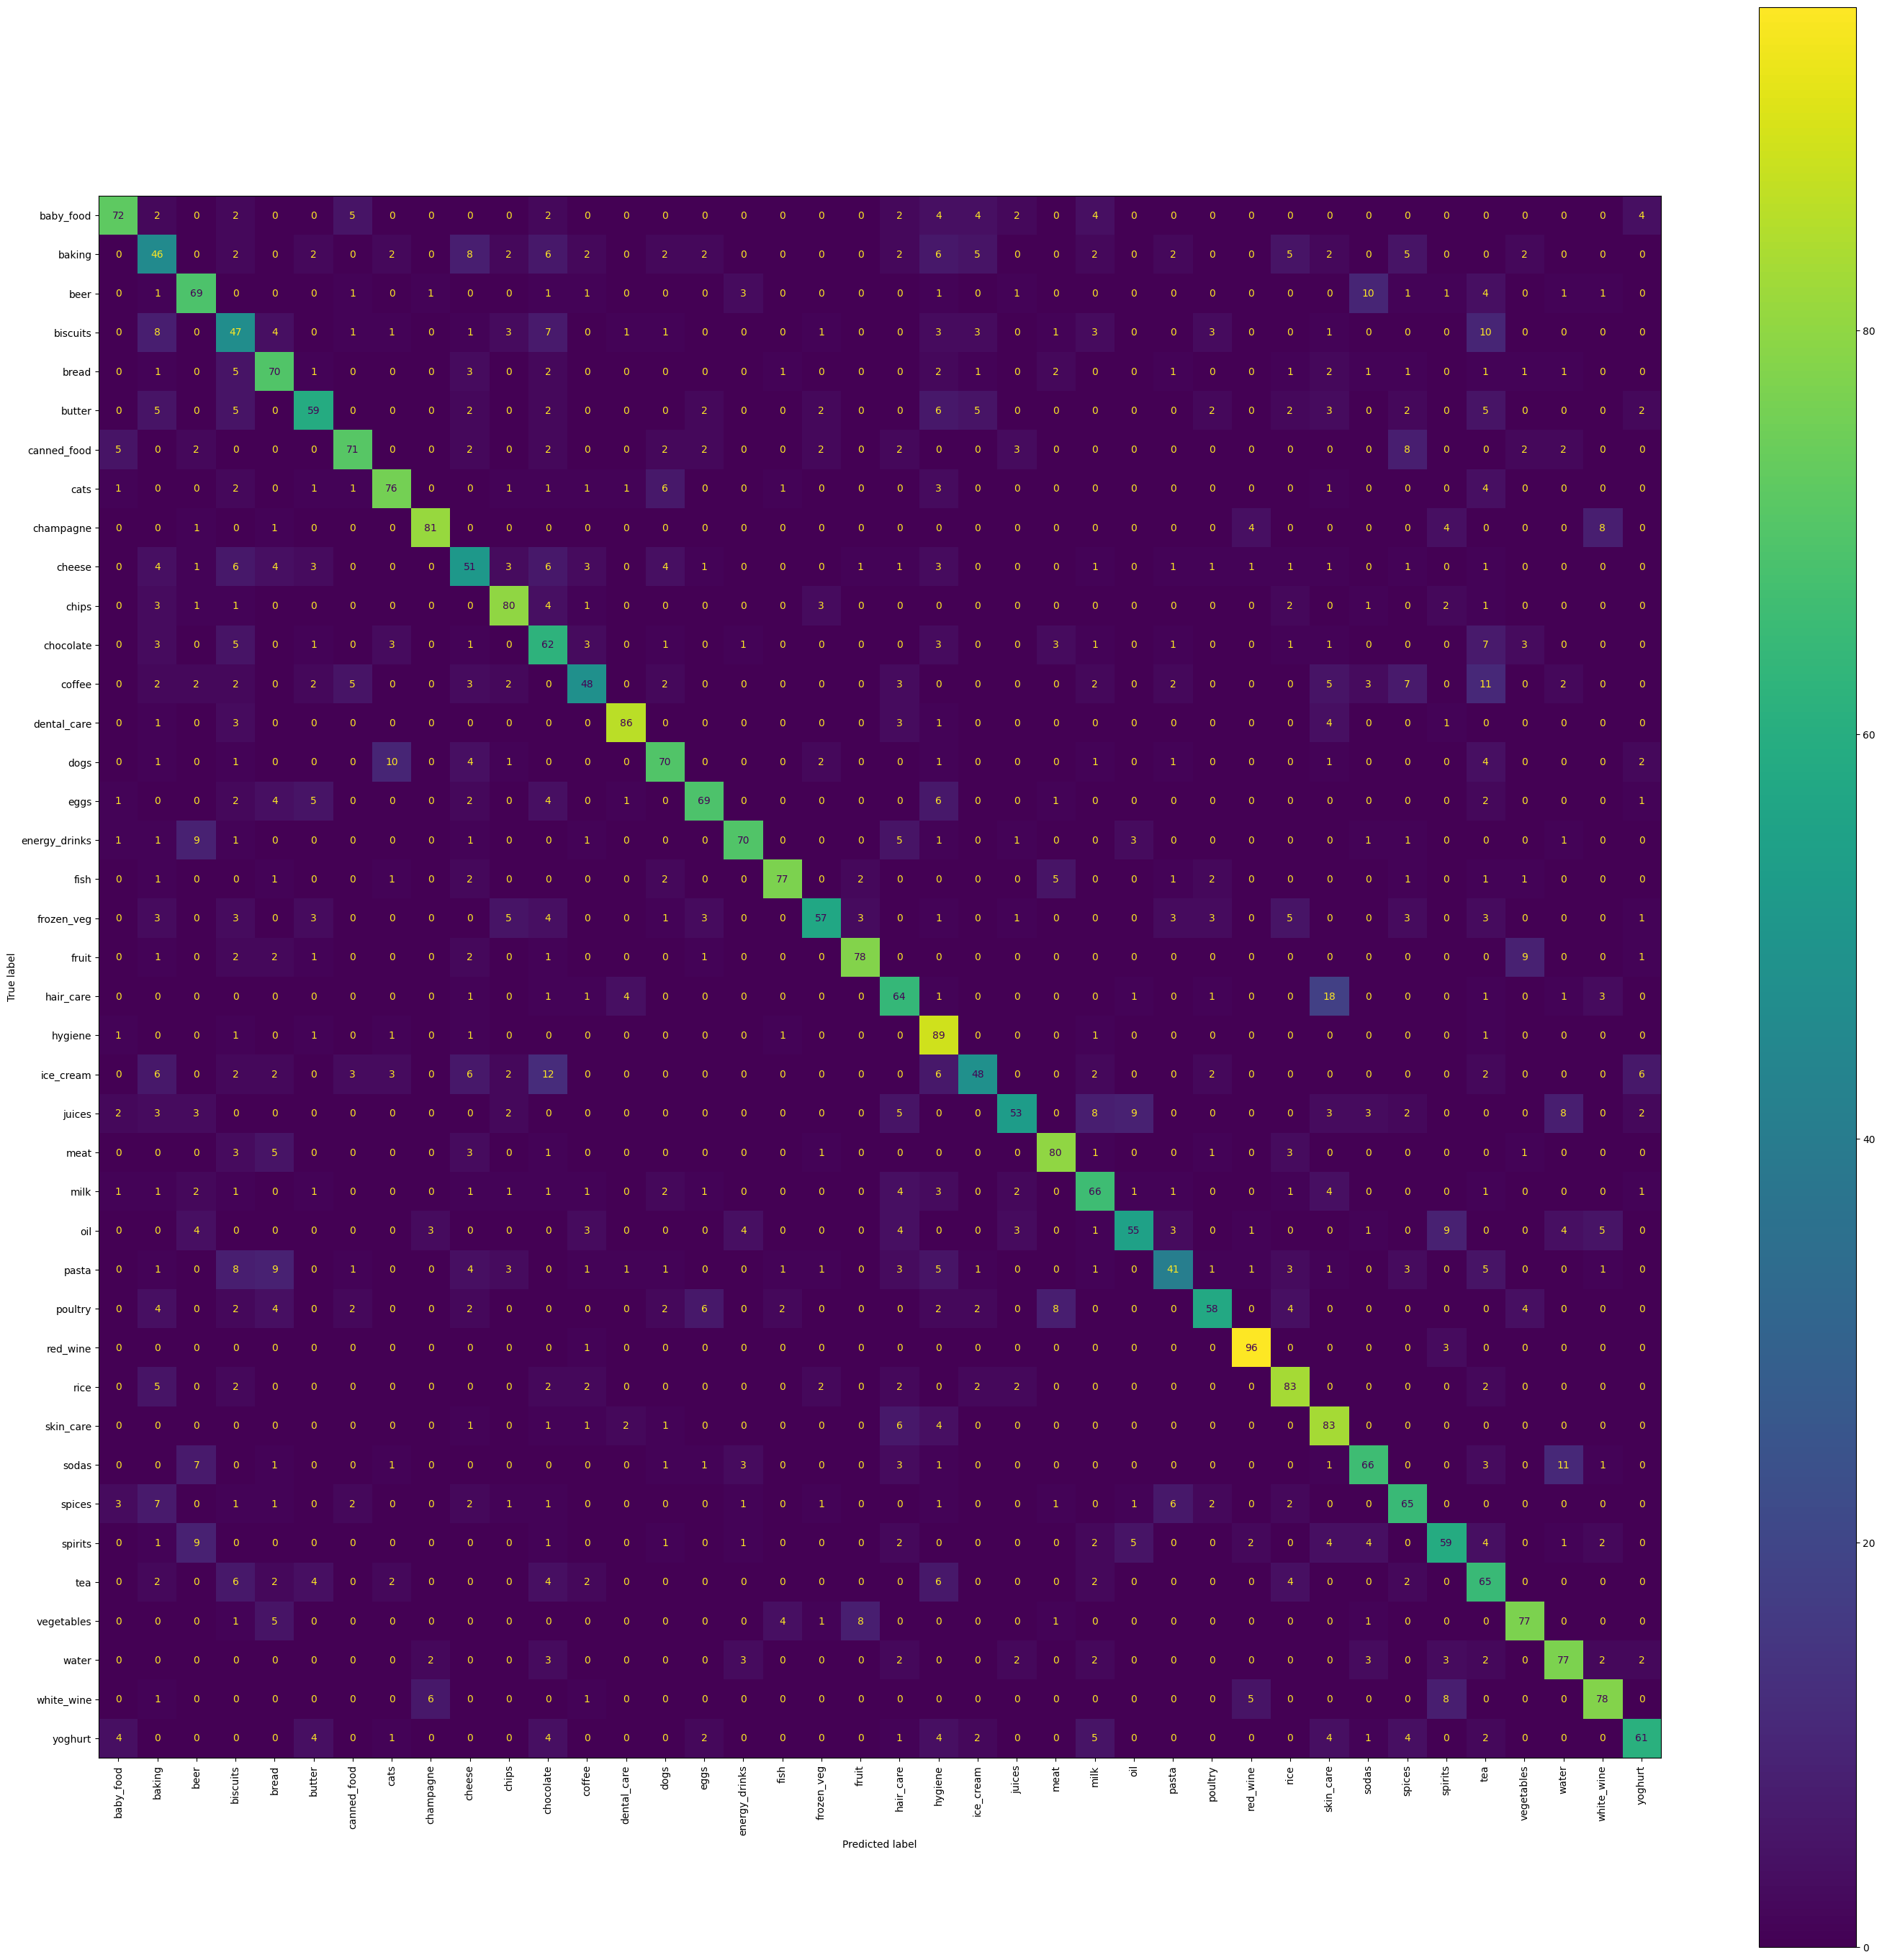

In [13]:
from utils.confusion_matrix import plot_confusion_matrix

plot_confusion_matrix(model, test_ds, train_ds.class_names)

In [14]:
model.save('ready_models/inception_v3.keras')

In [16]:
import json

with open('models_histories/inception_v3.json', 'w') as f:
    json.dump(history_1.history, f, indent=4)

Text(0, 0.5, 'Валидационная точность')

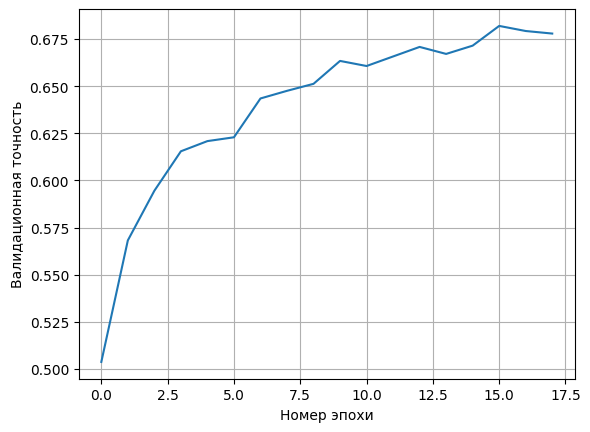

In [17]:
plt.plot(range(len(history_1.history['accuracy'])), history_1.history['val_accuracy'])
plt.grid()
plt.xlabel('Номер эпохи')
plt.ylabel('Валидационная точность')